In [1]:

import os
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler


# pvlib imports
import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib import irradiance


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

### TODOs: 

* RMSE Skill Implementation
    
    - What is the reference model?  == A linear regression on meteo on the aggregated data set


* Physical Modelling: 
    
    - Implement the "Best-Case" and "Worst-Case" Scenario

* ML Modelling: 
   
    - Choose starting month randomly
    - Sample for all systems -> STD
    - 

### General Questions

* Use real irradiance data or historical forecasts?

In [33]:
def physical_profile(row, df_irr):
    latitude, longitude, tilt, azimuth, capacity = row

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"][
        "open_rack_glass_glass"
    ]

    location = Location(latitude=latitude, longitude=longitude)

    pvwatts_system = PVSystem(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        module_parameters={"pdc0": capacity, "gamma_pdc": -0.004},
        inverter_parameters={"pdc0": capacity},
        temperature_model_parameters=temperature_model_parameters,
    )

    mc = ModelChain(
        pvwatts_system, location, aoi_model="physical", spectral_model="no_loss"
    )
    mc.run_model(df_irr)
    results = mc.results.ac

    df_results = pd.Series(results)
    df_results.index = df_results.index.tz_localize(None)
    df_results.index.name = "timestamp"
    df_results.name = str(tilt) + ";" + str(azimuth)

    return df_results


def pv_day_filter(data, site, tilt, azimuth, timesteplen):

    index = data.index
    times = pd.date_range(index[0], index[-1], freq=str(timesteplen) + "T")
    clearsky = site.get_clearsky(times)
    solar_position = site.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=clearsky["dni"],
        ghi=clearsky["ghi"],
        dhi=clearsky["dhi"],
        solar_zenith=solar_position["apparent_zenith"],
        solar_azimuth=solar_position["azimuth"],
    )

    day_index = POA_irradiance[POA_irradiance["poa_global"] > 0].index

    data_day_values = data.reindex(day_index).dropna()

    return data_day_values


def get_accuracies_per_month(df, model_type):

    accuracy_dictionary = {}

    start_date = pd.Timestamp("2015-02-01 14:00:00")
    for month in range(9):

        train_end = start_date + pd.Timedelta(weeks = 4*month)
        train = df[start_date:train_end]
        if month > 0:
            test = pd.concat([df[:start_date], df[train_end:]], axis = 0)
        else:
            test = df[train_end:]

        scaler_ml_features = MinMaxScaler()
        scaler_ml_target = MinMaxScaler()

        X_train, y_train = scaler_ml_features.fit_transform(train.iloc[:,1:]), scaler_ml_target.fit_transform(train.iloc[:,:1])
        X_test, y_test = scaler_ml_features.transform(test.iloc[:,1:]), scaler_ml_target.transform(test.iloc[:,:1])


        model = model_type()
        model.fit(X = X_train, y = y_train)
        predictions = model.predict(X_test)

        gt_unscaled = scaler_ml_target.inverse_transform(y_test.reshape(-1,1))
        predictions_unscaled = scaler_ml_target.inverse_transform(predictions.reshape(-1,1))

        df_y_test = pd.DataFrame({"ground_truth":gt_unscaled.squeeze(), "predictions": predictions_unscaled.squeeze()}, index = test.index)

        rmse = mean_squared_error(y_true=df_y_test["ground_truth"], y_pred= df_y_test["predictions"], squared=False)
        r2 = r2_score(y_true=df_y_test["ground_truth"], y_pred= df_y_test["predictions"])

        accuracy_dictionary[month] = rmse, r2 

    df_accuracy = pd.DataFrame(accuracy_dictionary, index = ["rmse", "r2"]).T.reset_index()

    return df_accuracy, df_y_test


def concat_physical_ml_accuracies(df_compare, df_accuracy):
    rmse_phys = mean_squared_error(df_compare.iloc[:,:1], df_compare.iloc[:,1:], squared=False)
    r2_phys = r2_score(df_compare.iloc[:,:1], df_compare.iloc[:,1:])
    df_accuracy.loc[-1,:] = -1, rmse_phys, r2_phys 

    return df_accuracy


def get_df_compare_physical(df_meta, df_power, df_irr):

    """
    df_irr must have columns ['ghi', 'dni', 'dhi']

    """

    df_compares = []
    
    for system_id in df_meta.index:
        df_meta_data_id = df_meta.loc[system_id]
        tilt, azimuth = df_meta_data_id["tilt"], df_meta_data_id["azimuth"]
        location = Location(latitude=df_meta_data_id["latitude"], longitude=df_meta_data_id["longitude"])


        df_physical_profile = physical_profile(df_meta_data_id, df_irr).to_frame("physical_profile").resample("15T").mean().fillna(method = "bfill", limit = 4) 
        df_physical_profile = pv_day_filter(df_physical_profile, location, tilt, azimuth, 15)

        df_power_id = df_power[[str(system_id)]].resample("15T").mean()

        df_compare = pd.merge(df_power_id, df_physical_profile, left_index=True, right_index=True, how = "right").fillna(method = "bfill", limit= 4).dropna()
        
        df_compares.append(df_compare)
        
    return df_compares


def calc_accuracies_from_df_compares(df_compares, metrics):


    metrics_names = [metric.__name__ for metric in metrics]
    df_acc = pd.DataFrame(columns = metrics_names, index = range(len(df_compares)))


    for i, df_compare in enumerate(df_compares):
        for metric in metrics:
            metric_name = metric.__name__
            df_acc.loc[i, metric_name] = metric(df_compare.iloc[:,:1],df_compare.iloc[:,1:])

    
    #transforming the mse into the rmse
    if "mean_squared_error" in metrics_names:

        df_acc["root_mean_squared_error"] = np.sqrt(df_acc["mean_squared_error"].astype(int))

        df_acc.drop(["mean_squared_error"], axis = 1, inplace=True)

    return df_acc



def realistic_case_round(value, interval):

    """
    Rounding the tilt to 10th degrees.
    """
    rounded_value = round(value / interval) * interval
    
    return rounded_value

In [4]:
# Importing and merging the meta data; the optimized one is based on the tilt and azimuth inference script i wrote. 

df_meta = pd.read_csv("../../../Input_Data/Meta_Data_PV_Optimised.csv", index_col = 0)
df_meta_original = pd.read_csv("../../../Data/System/PV system information dataset TU WIEN.csv", sep = ";", index_col = 0)
df_meta_data = pd.merge(df_meta_original, df_meta, left_index=True, right_index=True)
df_meta_data["tilt"] = df_meta_data["tilt_finetuned"] 
df_meta_data["azimuth"] = df_meta_data["azimuth_finetuned"]
df_meta_data = df_meta_data.iloc[:,1:-2]



In [50]:
df_meteo_sol = pd.read_csv("../../../Input_Data/ghi_dni_dhi.csv", index_col=0, parse_dates=True).resample("15T").mean() # more complete than the other one
df_meteo_sol = df_meteo_sol[['ghi', 'dni', 'dhi']]
df_irr = df_meteo_sol 


In [45]:
# This is weather station irradiance data from Utrecht. There are some data points missing and the data is generally more volatile. As a result the data from solcast, which is based on satelite imagery, was selected. 

#df_meteo = pd.read_csv("/Users/nikolaushouben/Library/Mobile Documents/com~apple~CloudDocs/PhD_Icloud/PhD_Papers/Paper_2_Collaborative Forecasting/Data/Meteo/irradiance_data-2014_2017.csv", index_col=0, parse_dates=True)
#df_meteo = df_meteo[['GHI', 'DNI', 'DHI']]
#df_meteo.columns = ['ghi_', 'dni_', 'dhi_']
#df_meteo = df_meteo.resample("15T").mean()
#df_irr = df_meteo
#df_irr.index = df_irr.index.tz_localize(tz = None)


In [51]:
df_power = pd.read_csv("../../../Input_Data/PV_System_Power.csv", index_col=0, parse_dates=True).resample("15T").mean()

# For subsequent comparison we need to select only those timestamps which are present in both dataframes. 
df_irr = df_irr.reindex(df_power.index)
df_irr = df_irr.dropna()
df_power = df_power.reindex(df_irr.index).dropna()

# Physical Modelling

## 0) Best-Case (Everything is known)

<BarContainer object of 2 artists>

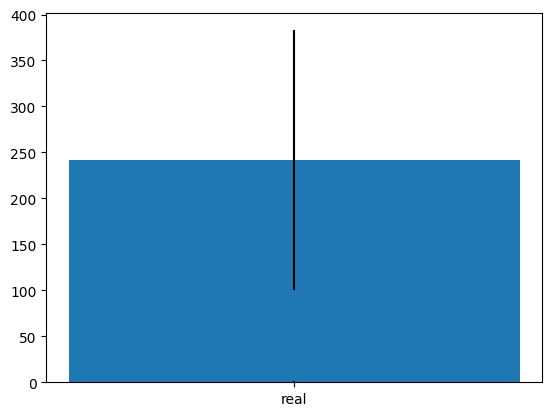

In [52]:
df_compares_best_case_physical = get_df_compare_physical(df_meta_data, df_power, df_irr)
df_acc_best = calc_accuracies_from_df_compares(df_compares_best_case_physical, [mean_squared_error, r2_score])
mean_0 = df_acc_best.mean()
std_0 = df_acc_best.std()
plt.bar(["real"], mean_0, 0.5, yerr=std_0)

In [57]:
mean_best

r2_score                     0.829372
root_mean_squared_error    241.647750
dtype: float64

## 1) Realistic-Case (Estimation by the Installer, Exact Location)

In [58]:
df_meta_data_realistic_case = df_meta_data
df_meta_data_realistic_case["tilt"] = df_meta_data_realistic_case["tilt"].apply(lambda x: realistic_case_round(x, 10))
df_meta_data_realistic_case["azimuth"] = df_meta_data_realistic_case["azimuth"].apply(lambda x: realistic_case_round(x, 45))

<BarContainer object of 2 artists>

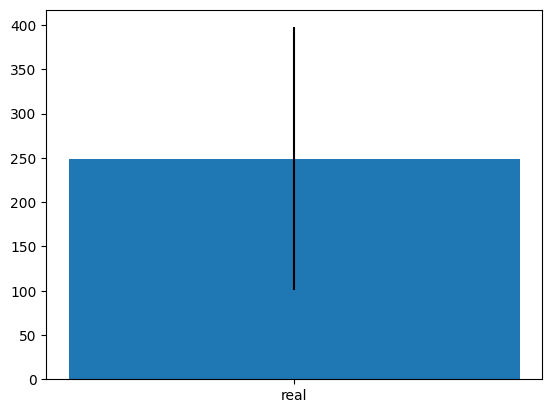

In [59]:
df_compares_realistic_case_physical = get_df_compare_physical(df_meta_data_realistic_case, df_power, df_irr)
df_acc_real = calc_accuracies_from_df_compares(df_compares_realistic_case_physical, [mean_squared_error, r2_score])
mean_1 = df_acc_real.mean()
std_1 = df_acc_real.std()
plt.bar(["real"], mean_1, 0.5, yerr=std_1)

## 2) Medium-Case (Random Guessing, exact locations)

In [82]:
means = []
stds = []
for i in range(10):
    tilts = np.random.randint(10, 60, (df_meta.shape[0]))
    azimuths = np.random.randint(0, 360, (df_meta.shape[0]))
    df_meta_data_guess_angles = df_meta_data
    df_meta_data_guess_angles["tilt"] = tilts
    df_meta_data_guess_angles["azimuth"] = azimuths
    df_compares_guessed_angles = get_df_compare_physical(df_meta_data_guess_angles, df_power, df_irr)
    df_acc_guessed = calc_accuracies_from_df_compares(df_compares_guessed_angles, [mean_squared_error, r2_score])
    means.append(df_acc_guessed.mean())
    stds.append(df_acc_guessed.std())


In [87]:
r2_mean, rmse_mean = zip(*means)
r2_std, rmse_std = zip(*stds)

<BarContainer object of 1 artists>

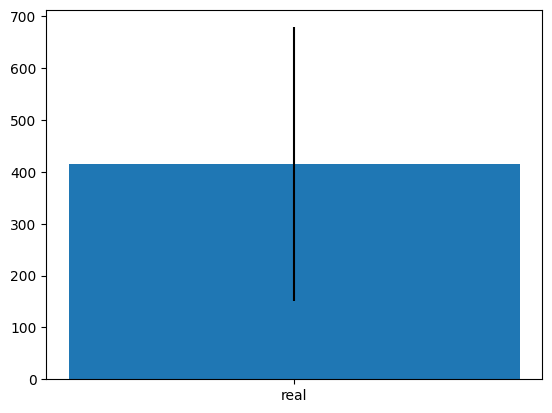

In [90]:
mean_2 = np.mean(rmse_mean)
std_2 = np.mean(rmse_std)
plt.bar(["real"], mean_2, 0.5, yerr=std_2)

## 3) Known Angles but average location

<BarContainer object of 1 artists>

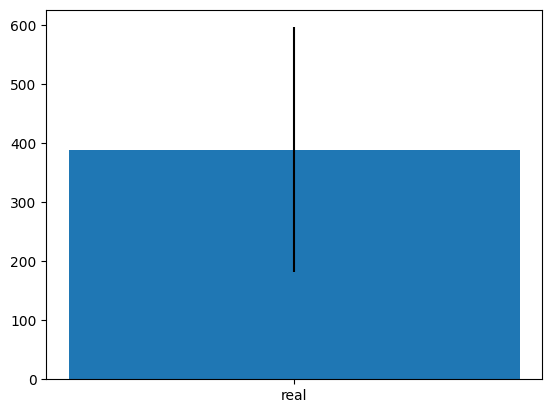

In [97]:
df_loc = df_meta_data
df_loc[["latitude", "longitude"]]= round(df_loc.mean(axis = 0)[["latitude", "longitude"]])
df_loc_compare = get_df_compare_physical(df_loc, df_power, df_irr)
df_acc_loc = calc_accuracies_from_df_compares(df_loc_compare, [mean_squared_error, r2_score])


<BarContainer object of 1 artists>

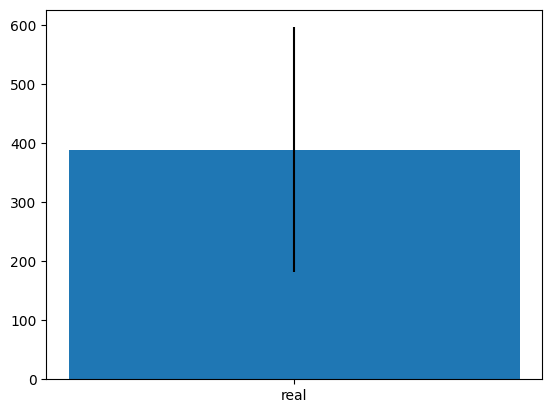

In [102]:

mean_3_r2, mean_3_rmse = df_acc_loc.mean()
std_3_r2, std_3_rmse = df_acc_loc.std()
plt.bar(["real"], mean_3_rmse, 0.5, yerr=std_3_rmse)

## 4) Unknown Angles and Unknown Locations

# ML Modelling